Initial configuration to train the classifier

In [1]:
# Need this specific version as the best model was trained with it
!pip3 install scikit-learn==0.22.2.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 13.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.2.post1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.2.post1 which is incompatible.


In [2]:
# Public dataset for spam messages
!wget -L https://raw.githubusercontent.com/itlovaz/spam-classifier/main/dataset/spam.csv
# required fro sentence-transformers
!apt-get install libffi-dev

!pip install -U sentence-transformers
# to store the model(s)
!mkdir sentence-transformers

--2022-07-12 22:33:16--  https://raw.githubusercontent.com/itlovaz/spam-classifier/main/dataset/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.005s  

2022-07-12 22:33:16 (93.3 MB/s) - ‘spam.csv’ saved [503663/503663]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.
Need to get 156 kB of archives.
After this operation, 362 kB o

Import the required libraries

In [3]:
import os
import re
import sys
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

Define some functions

In [4]:
# 0 = ham, 1 = spam
def convert_label_to_int(value):
  return 0 if value == 'ham' else 1
def convert_int_to_label(value):
  return 'ham' if value == 0 else 'spam'


# lowercase, remove extra white spaces
def preprocess_text(text):
  text = text.lower().strip() 
  text = re.sub('[^a-zA-Z]',' ',text)
  text = re.sub(' +', ' ', text)
  return text


def prediction(text, encoder, model):
  predict_data = encoder.encode([text])

  return 'spam' if model.predict(predict_data)[0] == 1 else "ham"


# to read the dataset file
def read_csv(name = "spam.csv", fix_dataset = True):
  df=pd.read_csv(name, encoding='ISO-8859-1')

  # the public dataset need some adjustments
  if fix_dataset:
    df=df.iloc[1:]
    df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
    df = df.rename(columns = {"v2" : "Message", "v1":"Label"})

  return df

Traning

In [5]:
# other models can be appended here (https://huggingface.co/models?library=sentence-transformers)
models_to_train = ['sentence-transformers/distiluse-base-multilingual-cased-v2', "sentence-transformers/all-MiniLM-L6-v2"]

for mtt in models_to_train:

  start = time.time()

  # read and prepare the data
  df = read_csv()
  df['Label'] = df['Label'].apply(convert_label_to_int)
  df['Message'] = df['Message'].apply(preprocess_text)

  # Compute embeddings with the pretrained model 
  # NOTE: the download may fail in Colab, just restart the runtime and run until it works...
  Encoder = SentenceTransformer(mtt)
  # Encode text into vectors
  embeddings = Encoder.encode(df["Message"].values) 

  # Prepare the train and test data
  x = embeddings
  y = df["Label"].values
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

  print(f"Training set of {len(X_train)} inputs")
  print(f"Test set of {len(X_test)} inputs")

  # Train the classifier
  classifier = SVC(kernel = 'linear')
  print(f"Training {mtt} ...")
  classifier.fit(X_train,y_train)

  y_pred_svc = classifier.predict(X_test)
  print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")

  # Save the model
  print("Saving model...")
  dump(classifier, mtt + '.joblib')
  print("Model saved!")
  end = time.time()
  print("Total time: " + str(end - start))

print("Training finished!")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Training set of 4456 inputs
Test set of 1115 inputs
Training sentence-transformers/distiluse-base-multilingual-cased-v2 ...
Accuracy: 0.9883408071748879
Saving model...
Model saved!
Total time: 69.06473183631897


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Training set of 4456 inputs
Test set of 1115 inputs
Training sentence-transformers/all-MiniLM-L6-v2 ...
Accuracy: 0.9766816143497757
Saving model...
Model saved!
Total time: 24.20859146118164
Training finished!


CHECKSPAM

In [6]:
# Set this to True if you want to test out the best model
use_best_model = True
if(use_best_model):
  !wget -L https://raw.githubusercontent.com/itlovaz/spam-classifier/main/models/model.joblib

--2022-07-12 22:35:22--  https://raw.githubusercontent.com/itlovaz/spam-classifier/main/models/model.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1581985 (1.5M) [application/octet-stream]
Saving to: ‘model.joblib’

model.joblib        100%[===================>]   1.51M  --.-KB/s    in 0.006s  

2022-07-12 22:35:22 (244 MB/s) - ‘model.joblib’ saved [1581985/1581985]



In [7]:
model_to_use = 'sentence-transformers/distiluse-base-multilingual-cased-v2' if use_best_model else "sentence-transformers/all-MiniLM-L6-v2"
Encoder = SentenceTransformer(model_to_use)

# Run the model to predict the label
clf = load(("model" if use_best_model else model_to_use) + '.joblib')
messages_to_test = [
                    "Free money: click the link below", 
                    "Wanna hang out tonight?", 
                    "Buy your stock now!"
                    ]
for msg in messages_to_test:
  print(f"{msg} => {prediction(msg, Encoder, clf)}")

Free money: click the link below => spam
Wanna hang out tonight? => ham
Buy your stock now! => ham


Save embeddings and visualize

Explainability: 0.9306679964065552


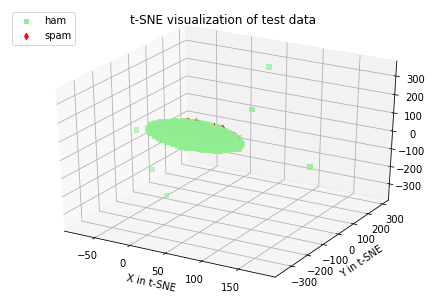

In [8]:
model_to_use = 'sentence-transformers/distiluse-base-multilingual-cased-v2' if use_best_model else "sentence-transformers/all-MiniLM-L6-v2"

# read and prepare the data
df = read_csv()
df['Label'] = df['Label'].apply(convert_label_to_int)
df['Message'] = df['Message'].apply(preprocess_text)

# Compute embeddings with the pretrained model 
Encoder = SentenceTransformer(model_to_use)
# Encode text into vectors
embeddings = Encoder.encode(df["Message"].values) 

# Save the embeddings
np.save('full_embeddings', embeddings)

# Load the embeddings
embeddings = np.load('full_embeddings.npy')

# Compute the predictions
model = load(("model" if use_best_model else model_to_use) + '.joblib')
predictions = np.array([])
for emb in embeddings:
    emb = emb.reshape(1, -1)
    output = model.predict(emb)[0]
    predictions = np.append(predictions, [output])

x = embeddings
y = predictions

# Visualize the data
standard = StandardScaler()
x_std = x

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
mpl = {0: 'ham', 1: 'spam'}

warnings.filterwarnings("ignore")

pca_50 = PCA(n_components=256)
pca_result_50 = pca_50.fit_transform(x_std)
print(f'Explainability: {np.sum(pca_50.explained_variance_ratio_)}')

tsne = TSNE(n_components=3, random_state=26) 
x_test_2d = tsne.fit_transform(pca_result_50)

markers = ('s', 'd', 'o', '^', 'v', '8', 's', 'p', "_", '2')

color_map = {0: 'lightgreen', 1: 'red'}

fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)

for idx, cl in enumerate(np.unique(y)):
    ax.scatter(x_test_2d[y == cl, 0], x_test_2d[y == cl, 1], x_test_2d[y == cl, 2], c=color_map[idx], marker=markers[idx], label=mpl[cl])
    
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()




